# Introduction

In this example, we shall try to learn an abitrary $2 \times 2$ 
unitary matrix $U$, via gradient descent. We shall start with a 
random parameterized unitary matrix $U(\phi, \theta, \omega)$,
which is essentially a rotation around $Z-Y-Z$ axes. 
The $2 \times 2$ unitary matrix takes the form


$U(\phi, \theta, \omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
 e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
 e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
 \end{bmatrix}$
 
 
This comes with `qgrad` under `rot`.


Here the input dataset consists of $2 \times 1$ kets, call them
$| \Psi_{i} \rangle$ and output dataset is the action of the 
target unitary $U$ on these kets, $U |\Psi_{i} \rangle$. The 
maximum value of $i$ is $80$, meaning that merely use 80
data points (kets in this case) to efficiently learn the 
target unitary, $U$.


This tutorial is different from the 
[Qubit Rotation](https://github.com/qgrad/qgrad/blob/master/examples/QubitRotation.py),
in that it learns the unitary matrix to not take a fixed _specific_
state to another _fixed_ state. Here the unitary
$U(\phi, \theta, \omega)$ is learnt to evolve _any_ same
dimensional ket as the target unitary, $U$ would evolve it.


**Note**: Another version of this tutorial is implemented 
without `qgrad` that uses the parametrization used in 
[Seth Lloyd and Reevu Maity, 2020](https://arxiv.org/pdf/1901.03431.pdf)
and verifies the results of that paper. This tutorial 
shows similar results, with different unitary paramterization
$U(\phi, \theta, \omega)$ as shown above since the
parametrization used in the original paper uses hamiltonians 
in the powers of exponents, whose autodifferentiation is
not currently supported in JAX. For further reading 
on this autodifferentiation incompatibility, please 
refer to this companion 
[blog](https://araza6.github.io/posts/hamiltonian-differentiation/)


In [1]:
import jax.numpy as jnp
from jax import grad
from jax.experimental import optimizers
from jax.random import PRNGKey, uniform

import numpy as onp

#Visualization
import matplotlib.pyplot as plt 
from matplotlib import cm

from qgrad.qgrad_qutip import fidelity, rot, Unitary

from qutip import rand_ket # only to make the dataset

from scipy.stats import unitary_group

In [2]:
def make_dataset(m, d):
    """Prepares a dataset of input and output 
    kets to be used for training.
    
    Args:
        m (int): Number of data points, 80% of 
            which would be used for training
        d (int): Dimension of a (square) unitary
            matrix to be approximated
    
    Returns:
        tuple: tuple of lists containing (numpy arrays of)
            input and output kets respectively
    """
    ket_input = []
    ket_output = [] 
    for i in range(m):
        ket_input.append(jnp.array(rand_ket(d, seed=300).full()))
        #Output data -- action of unitary on a ket states
        ket_output.append(jnp.dot(tar_unitr, ket_input[i]))  
    
    return (ket_input, ket_output)

m = 100 # number of training data points
N = 8 # Dimension of the unitary to be learnt
train_len = int(m * 0.8)
tar_unitr = jnp.asarray(unitary_group.rvs(N))
ket_input, ket_output = make_dataset(m, N)

/home/asad/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Cost Function

We use the same cost function as the authors
[Seth Lloyd and Reevu Maity, 2020](https://arxiv.org/pdf/1901.03431.pdf)
define 

$\begin{equation} \label{err_ps}
         E = 1 - (\frac{1}{M})\sum_{i} \langle \psi_{i}|U^{\dagger} U(\phi, \theta, \omega)|\psi_{i}\rangle
 \end{equation}$, 

where $ |\psi_{i} \rangle$ is the training (or testing) 
data points -- in this case, kets. And $U$ and 
$U(\phi, \theta, \omega)$ are the target and
parameterized unittaries respectively.

Since we have only three parameters to tune,
it might be instructive to visualize the loss
landscape over the first two parameters, $\phi$
and $\theta$. 

In [3]:
def cost(params, inputs, outputs):
    r"""Calculates the cost/error on the whole 
        training dataset.
    
    Args:
        params: parameters :math:`\phi, \theta` and :math:`\omega`
        inputs: input kets :math:`|\psi_{l}>` in the dataset
        outputs: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` 
            in the dataset
    
    Returns:
        float: Cost (evaluated on the entire dataset) of parametrizing 
            :math:`U(\phi, \theta, \omega)` with `params`                  
    """
    loss = 0.0
    thetas, phis, omegas = params
    unitary = Unitary(N)(thetas, phis, omegas)
    for k in range(train_len):
        pred = jnp.dot(unitary, inputs[k]) 
        loss += jnp.absolute(jnp.real(jnp.dot(outputs[k].conjugate().T, pred)))

    loss = 1 - (1 / train_len) * loss
    return loss[0][0]

In [4]:
def test_score(params, inputs, outputs):
    """Calculates the average fidelity between the
        predicted and output kets for given parameters
        (averaged over the whole training set).
       
       Args:
           params: parameters :math:`\phi, \theta` and :math:`\omega`
           inputs: input kets :math:`|\psi_{l}>` in the dataset 
           outputs: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` 
               in the dataset
           
       Returns:
           float: fidelity between :math:`U(\phi, \theta, \omega)*|ket_{input} \rangle`
               and the output (label) kets for given `params`
            
       """
    fidel = 0
    thetas, phis, omegas = params
    unitary = Unitary(N)(thetas, phis, omegas)
    for i in range(train_len):
        pred = jnp.dot(unitary, inputs[i])
        step_fidel = fidelity(pred, outputs[i])
        fidel += step_fidel
        
        
    return (fidel / train_len)[0][0]

In [5]:
thetas = uniform(PRNGKey(0), ((N * (N - 1) // 2),),
                 minval = - jnp.pi, maxval = jnp.pi)
phis = uniform(PRNGKey(1), ((N * (N - 1) // 2),), 
               minval = - jnp.pi, maxval= jnp.pi)
omegas = uniform(PRNGKey(2), (N,), 
                 minval = - jnp.pi, maxval = jnp.pi)
params = [thetas, phis, omegas]

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)
opt_state = opt_init(params)

def step(i, opt_state, opt_update):
    params = get_params(opt_state)
    g = grad(cost)(params, ket_input, ket_output)
    return opt_update(i, g, opt_state)

epochs = 50
loss_hist = []
params_hist = []
fidel_hist = []

for i in range(epochs):
    opt_state = step(i, opt_state, opt_update)
    params = get_params(opt_state)
    params_hist.append(params)
    loss = cost(params, ket_input, ket_output)
    loss_hist.append(loss)
    avg_fidel = test_score(params, ket_input, ket_output)
    fidel_hist.append(avg_fidel)
    progress = [i+1, loss, avg_fidel]
    if (i % 10 == 9):
        print("Epoch: {:2f} | Loss: {:3f} | Fidelity: {:3f}".format(*jnp.asarray(progress)))

Epoch: 10.000000 | Loss: 0.047677 | Fidelity: 0.907110
Epoch: 20.000000 | Loss: 0.019404 | Fidelity: 0.962204
Epoch: 30.000000 | Loss: 0.004455 | Fidelity: 0.991216
Epoch: 40.000000 | Loss: 0.001617 | Fidelity: 0.996984
Epoch: 50.000000 | Loss: 0.000722 | Fidelity: 0.998561


In [6]:
theta_arr = [param_vec[0] for param_vec in params_hist]
phi_arr = [param_vec[1] for param_vec in params_hist]
omega_arr = [param_vec[2] for param_vec in params_hist]
path_cost = []
for theta, phi, omega in zip(theta_arr, phi_arr, omega_arr):
    path_cost.append(
        cost([theta, phi, omega], ket_input, ket_output)
    )
path_theta = [param_vec[0][0] for param_vec in params_hist]
path_phi = [param_vec[1][0] for param_vec in params_hist]

# Analyzing Learning Routine

We see that we _efficiently_ (with $~99 \%$ fidelity)
reconstruct the target unitary $U$ starting from an 
initial guess 0, for all the three angles of 
$U(\phi, \theta, \omega)$. We merely use $80$
examples for training, and in $40$ crude gradient
steps, we almost perfectly approximate the target
unitary, $U$. Below is a plot of how fidelity increases
and loss gets down to zero in the training schedule.

In the graph below, $M$ represents
the total size of the train set, $\psi_{label}$ 
represents the resulting ket the evolved under 
the target unitary, $U$ as $U |\psi_{i} \rangle$ and 
$\psi_{pred}$ represents the ket $\psi_{i}$
evolved under $U(\phi, \theta, \omega)$
as $ U(\phi, \theta, \omega) | \psi_{i} \rangle$.
Each marker is the fidelity between the predicted
and the target/label kets is averaged over the
whole train set

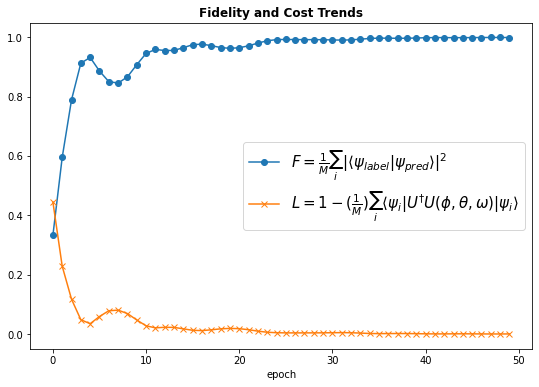

In [7]:
plt.figure(figsize=(9, 6))

plt.plot(fidel_hist, marker = 'o', 
         label=r"$F = \frac{1}{M}\sum_{i}| \langle \psi_{label} | \psi_{pred} \rangle |^2$")

plt.plot(loss_hist, marker = 'x',
        label=r"$L = 1 - (\frac{1}{M})\sum_{i}\langle \psi_{i} | U ^{\dagger} U(\phi, \theta, \omega) | \psi_{i} \rangle$")

plt.title("Fidelity and Cost Trends", fontweight = "bold")
plt.legend(["Fidelity","Loss"])
plt.xlabel("epoch")
plt.legend(loc=0, prop = {'size': 15})

# Testing on unseen kets

We reserved the last $20$ kets for testing. Now we shall apply
our learned unitary matrix, call it $U_{opt}(\phi, \theta, \omega)$
to the unseen kets and measure the fidelity of the evolved ket
under $U_{opt}(\phi, \theta, \omega)$ with those that evolved 
under the target unitary, $U$.

Text(0, 0.5, 'Fidelity')

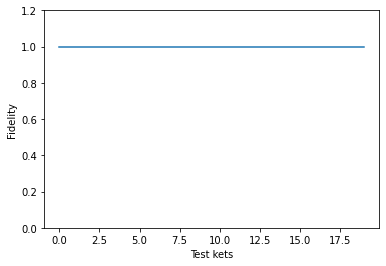

In [8]:
theta_opt, phi_opt, omega_opt = params_hist[-1]
opt_unitary = Unitary(N)(theta_opt, phi_opt, omega_opt)
fidel = []
for i in range(train_len, m): # unseen data
    pred = jnp.dot(opt_unitary, ket_input[i])
    fidel.append(fidelity(pred, ket_output[i])[0][0])
plt.plot(range(len(fidel)), fidel)
plt.ylim(0, 1.2)
plt.xlabel("Test kets")
plt.ylabel("Fidelity")

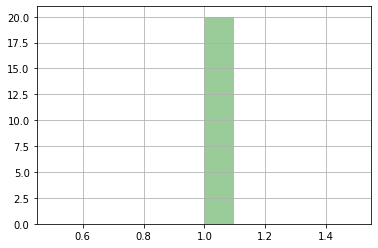

In [9]:
n, bins, patches = plt.hist(fidel, 10, facecolor='g', alpha=0.4)
#plt.xlim(0, 1)
plt.grid(True)

# References
1. Lloyd, Seth, and Reevu Maity. "Efficient implementation of unitary transformations." arXiv preprint arXiv:1901.03431 (2019).